In [1]:
# Package imports
from SGD.dynamics import Trainer
from SGD.data import DataGenerator , Perceptron , SkewedCumulant , SpikedCumulant
from SGD.plot_config import *
from SGD.functions import activations, get_activation
from SGD.utils import initialize_weights , make_params_dict , save_fig , save_data , load_data 

# Libraries
import numpy as np
import matplotlib.pyplot as plt
import time

# Plot styles
apply_general_styles()

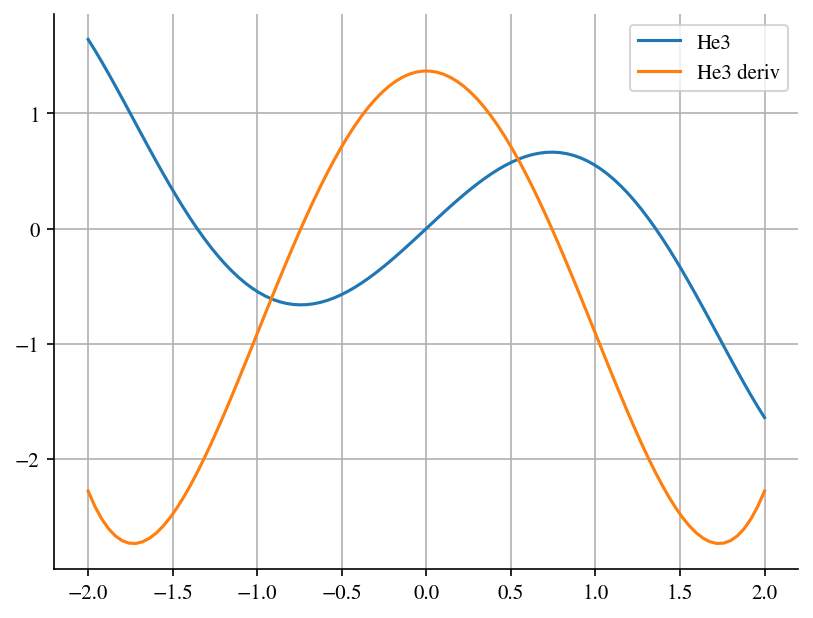

In [19]:

# spec = "He3"
spec = {'He1':0.0, 'He2':0.0, 'He3':0.0,
        'He4':0.0, 'He5':1.0,'relu':0.0,}
# spec = ['He3', 'He2']
f , df = get_activation(spec)
x = np.linspace(-2,2,100)
plt.plot(x , f(x) , label="He3")
plt.plot(x , df(x) , label="He3 deriv")
plt.grid()
plt.legend()


# Modified landscape

In [ ]:
a , b = np.random.randn(2,10)


array([-0.55680073, -1.65521962,  1.1270567 ,  1.26575642,  1.04983326,
        0.06556561, -0.68289163,  1.03785953, -0.75123821, -1.26811828])

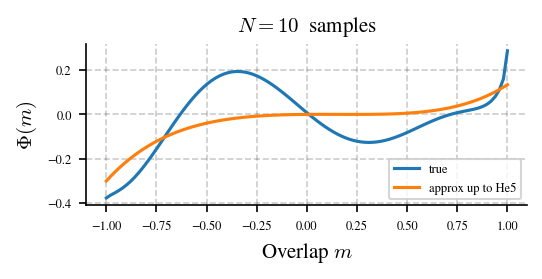

In [87]:
N = 10 # Number of repetition dataset
a , b = np.random.randn(2,N)
m = np.linspace(-1,1,100)

# Teacher - student activations
teacher_fun = get_activation('He3')[0]
student_fun = get_activation('He3')[0]

# True phi as sum of random projections
phi = 0.5*(teacher_fun(a[:,None]) + student_fun(m[None,:]*a[:,None] + np.sqrt(1 - m[None,:]**2)*b[:,None]))**2
phi = np.mean(phi , axis=0)
phi -= phi[len(m)//2]

# Approx phi
phi_apx = np.zeros_like(m)
for k , lb in enumerate(['He1','He2','He3','He4','He5']):
    hermite_k , _ = get_activation(lb)
    # Compute monte carlo estimate of hermite coefficients of teacher and student
    c_teach = (hermite_k(a) *teacher_fun(a)).mean()
    c_stud = (hermite_k(b) *student_fun(b)).mean()
    # Add term to the expansion
    phi_apx += c_stud*c_teach*m**(k+1)
    

set_font_sizes('tight')
fig , axes = create_fig()
ax = axes

ax.plot(m , phi , label="true")
ax.plot(m , phi_apx , label="approx up to He5")
ax.set_xlabel(r"Overlap $m$")
ax.set_ylabel(r"$\Phi(m)$")
ax.set_title(rf'$N = {N}$  samples')
ax.legend()
ax.grid(ls='--',lw=0.8,alpha=0.2,c='k')

# Run with random function


In [35]:
# Minimal Parameters
d = 100
spike = True
snr = 5.0
# teacher = ['He2','He3','He1']
teacher = 'relu'

loss = 'corr'
k = 3

N_steps = int(50*d**(k-1))
rng = np.random.default_rng()
N_walkers = 5
mode = 'online'  # 'repeat' or 'online'
p_repeat = 1.0
dataset_size = d

lr0 = 0.02
coeff = [1.0,0.5,0.2,0.1,0.05]

more_data = {}
for c in coeff:
    more_data[c] = {}
    for keff in [2,3]:
        print(f"Running c={c} , keff={keff}")
        student = [('He3',1.0), ('He2',c)]

        # lr = lr0* d**(-0.5*(keff)+1)
        lr = d**(-0.5*(keff)+1) if keff>2 else  np.log(d)**(-0.5)
        lr = lr0*lr
        # Initialize weights
        # np.random.seed()
        u_spike, w_initial = initialize_weights(d,m0=0.0,mode='fixed',N_walkers=N_walkers)

        # Initialize data model
        # data_sampler = SkewedCumulant(dim=d,spike=u_spike, snr=snr, rng=rng, p_spike=0.5, rho=0.7)
        # data_sampler = RademacherCumulant(dim=d,spike=u_spike, snr=snr, rng=rng,p_spike=1)
        data_sampler = Perceptron(dim=d,w_teacher=u_spike,teacher=teacher,rng=rng)


        # Initialize data generator
        data_generator = DataGenerator(data_sampler,N_walkers=N_walkers,mode=mode,dataset_size=dataset_size,p_repeat=p_repeat,variation='twice') 


        # Initialize Trainer
        trainer = Trainer(d, u_spike, student, loss, lr, data_generator,N_walkers=N_walkers)

        # Save data
        # tprints = np.unique(np.logspace(-0.1,np.log10(N_steps),500).astype(int))
        tprints = np.linspace(0,N_steps,500).astype(int)
        data = {'overlap':[],'times':[]}
        # w_initial = w_student.copy()
        # Run evolution
        t0 = time.time()
        print("Starting training...")
        for step, (w_student, flag , grad) in enumerate(trainer.evolution(w_initial, N_steps, progress=True)):
            if step in tprints: # Save some steps
                data['overlap'].append(w_student @ u_spike)
                data['times'].append(step)

        dt = time.time() - t0
        print(f"End training... Took = {dt/60:.4} min")

        # Optional Step
        for key in data:
            data[key] = np.array(data[key])
            print(key, data[key].shape)

        more_data[c][keff] = data

        # Save data
        # name_vars = ['d','snr']
        # params = make_params_dict(name_vars)
        # save_data(data,file_name='test',params=params,base_dir='../data')

        # Load data
        # data_loaded = load_data(file_name='test',params=params)


Running c=1.0 , keff=2
Starting training...


100%|██████████| 500000/500000 [00:34<00:00, 14476.79it/s]


End training... Took = 0.5757 min
overlap (499, 5)
times (499,)
Running c=1.0 , keff=3
Starting training...


100%|██████████| 500000/500000 [00:31<00:00, 15806.85it/s]


End training... Took = 0.5272 min
overlap (499, 5)
times (499,)
Running c=0.5 , keff=2
Starting training...


100%|██████████| 500000/500000 [00:31<00:00, 15790.03it/s]


End training... Took = 0.5278 min
overlap (499, 5)
times (499,)
Running c=0.5 , keff=3
Starting training...


100%|██████████| 500000/500000 [00:31<00:00, 15886.88it/s]


End training... Took = 0.5246 min
overlap (499, 5)
times (499,)
Running c=0.2 , keff=2
Starting training...


100%|██████████| 500000/500000 [00:31<00:00, 15806.22it/s]


End training... Took = 0.5275 min
overlap (499, 5)
times (499,)
Running c=0.2 , keff=3
Starting training...


100%|██████████| 500000/500000 [00:31<00:00, 15877.13it/s]


End training... Took = 0.5249 min
overlap (499, 5)
times (499,)
Running c=0.1 , keff=2
Starting training...


100%|██████████| 500000/500000 [00:31<00:00, 15808.43it/s]


End training... Took = 0.5272 min
overlap (499, 5)
times (499,)
Running c=0.1 , keff=3
Starting training...


100%|██████████| 500000/500000 [00:31<00:00, 15776.06it/s]


End training... Took = 0.5282 min
overlap (499, 5)
times (499,)
Running c=0.05 , keff=2
Starting training...


100%|██████████| 500000/500000 [00:31<00:00, 15769.73it/s]


End training... Took = 0.5285 min
overlap (499, 5)
times (499,)
Running c=0.05 , keff=3
Starting training...


100%|██████████| 500000/500000 [00:31<00:00, 15756.46it/s]

End training... Took = 0.5291 min
overlap (499, 5)
times (499,)


Figure saved on ../plots\2025-10 as mixed_student2_d100_losscorr_lr00.02_teacherrelu.png


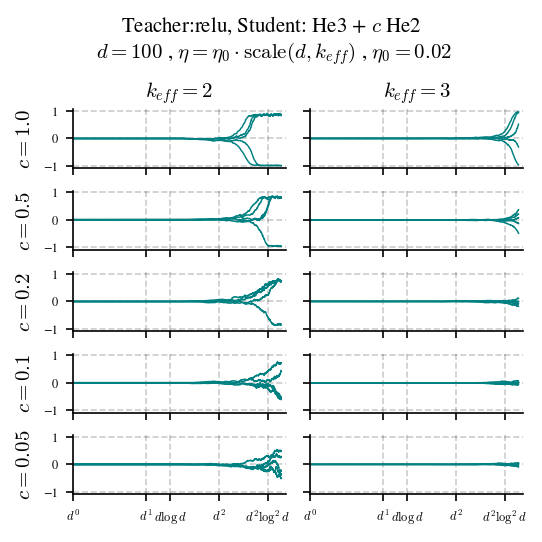

In [39]:
# Other variables
col = pc_colors[0]
# xtk = [d**i for i in range(4)]
# xlb = [rf'$d^{i}$' for i in range(4)]
# lr0 = 0.5
xtk = [1 , d , d*np.log(d), d**2, d**2*(np.log(d))**2]
xlb = [r'$d^0$', r'$d^1$', r'$d \log d$', r'$d^2$', r'$d^2 \log^2 d$']
# Create figure and plot and font setup
set_font_sizes('tight')
fig , axes = create_fig(nrows = len(coeff),ncols = 2,h=1.0,sharey=True)

for i , c in enumerate(coeff):
    for j , keff in enumerate([2,3]):
        ax = axes[i,j]
        if i == 0 : 
            ax.set_title(rf'$k_{{eff}}={keff}$')
        if j == 0 :
            ax.set_ylabel(rf'$c={c}$')
        data = more_data[c][keff]
        for w in range(N_walkers):
            ax.plot(data['times'],data['overlap'][:,w],color=col,lw=0.7)
            
        ax.set_xscale('log')
        ax.set_xticks(xtk,xlb)
        ax.grid(ls='--',lw=0.8,alpha=0.2,c='k')

title = r"Teacher:relu, Student: He3 + $c$ He2"+'\n'+rf" $d = {d}$ , $\eta = \eta_0 \cdot \text{{scale}}(d,k_{{eff}})$ , $\eta_0 = {lr0}$"
fig.suptitle(title)
# Save figure
params = make_params_dict(['d','loss','lr0','teacher'])
params
save_fig(fig, file_name='mixed_student2', params=params,date=True)

In [72]:
N=10000
x = np.random.randn(N)
s = np.sign(x)

# Compute the cosine similarity between a high dimensional vector and its binary representation

similarity = (x @ s) / (np.linalg.norm(x) * np.linalg.norm(s))
print(similarity)

0.796096566140653
